# Prosper Logit Model Example

This demonstrates a simple Logit model to predict defaults on Prosper data

In [1]:
pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.metrics as metrics

### Load data, inspect, subset to columns and loan terms of interest, format

In [3]:
#load and inspect
loans = pd.read_csv(r'C:\Users\al_ca\Dropbox\memphis\teaching\2024_spring\FIR 7840\data\prosper_short.csv', low_memory=False)
#loans = pd.read_csv(r'C:\Users\al_ca\Dropbox\memphis\teaching\2024_spring\FIR 7840\data\prosper\prosper.csv', low_memory=False)
#loans.head()

In [4]:
loans.columns

Index(['loan_number', 'amount_borrowed', 'borrower_rate', 'prosper_rating',
       'term', 'age_in_months', 'origination_date', 'days_past_due',
       'principal_balance', 'service_fees_paid',
       ...
       'CV21', 'CV22', 'CV23', 'CV24', 'TUFicoRange', 'TUFicoDate',
       'dti_wprosper_loan', 'CoBorrowerApplication', 'CombinedDtiwProsperLoan',
       'CombinedStatedMonthlyIncome'],
      dtype='object', length=880)

In [5]:
#Get just 3 yr loans
loans = loans.loc[loans['term']==36]

In [6]:
#Subset to columns of interest
#add fico
loans = loans[['loan_number', 'loan_status_description', 'origination_date', 'amount_borrowed', 'listing_monthly_payment', 
               'borrower_rate', 'stated_monthly_income', 'dti_wprosper_loan', 'prosper_rating', 'occupation']]

In [7]:
#what are the datatypes in each column?
loans.dtypes

loan_number                  int64
loan_status_description     object
origination_date            object
amount_borrowed            float64
listing_monthly_payment    float64
borrower_rate              float64
stated_monthly_income      float64
dti_wprosper_loan          float64
prosper_rating              object
occupation                  object
dtype: object

In [8]:
#count missing values
loans.isnull().sum()

loan_number                   0
loan_status_description       0
origination_date              0
amount_borrowed               0
listing_monthly_payment       0
borrower_rate                 0
stated_monthly_income         0
dti_wprosper_loan             0
prosper_rating                0
occupation                 1312
dtype: int64

In [9]:
#Make defaulted dummy column, throw away undecided/cancelled loans
loans['defaulted'] = 0
loans.loc[loans['loan_status_description']=='CHARGEOFF', 'defaulted'] = 1
loans.loc[loans['loan_status_description']=='DEFAULTED', 'defaulted'] = 1
loans.loc[loans['loan_status_description']=='CURRENT', 'defaulted'] = -1
loans.loc[loans['loan_status_description']=='CANCELLED', 'defaulted'] = -1
loans = loans.loc[loans['defaulted']>= 0]

In [10]:
#Format other columns of interest
loans['origination_date'] = pd.to_datetime(loans['origination_date'])
ratings = ['AA','A','B','C','D','E','HR']
category_rating = pd.api.types.CategoricalDtype(categories=ratings, ordered=True)
loans['prosper_rating'] = loans['prosper_rating'].astype(category_rating)

In [11]:
#Subset to just loans originated in 2015
loans = loans.loc[loans['origination_date'].dt.year == 2015]

In [12]:
#Inspect interest rate
loans['borrower_rate'].describe()

count    16452.000000
mean         0.131103
std          0.052385
min          0.060000
25%          0.092200
50%          0.119800
75%          0.160100
max          0.312500
Name: borrower_rate, dtype: float64

<Axes: >

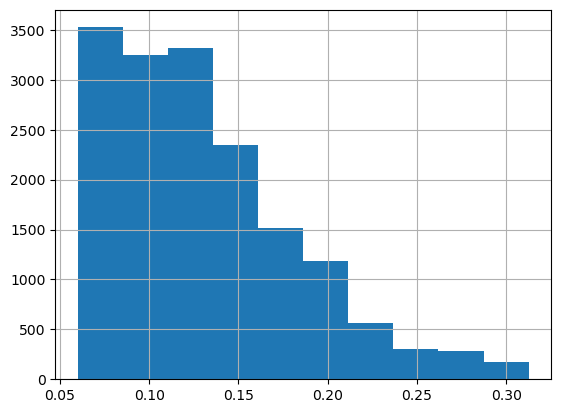

In [13]:
loans['borrower_rate'].hist()

In [14]:
#Inspect debt-to-income ratio
loans['dti_wprosper_loan'].describe()

count      16452.000000
mean       61512.532797
std       240274.833407
min            0.000000
25%            0.180000
50%            0.270000
75%            0.380000
max      1000000.000000
Name: dti_wprosper_loan, dtype: float64

<Axes: >

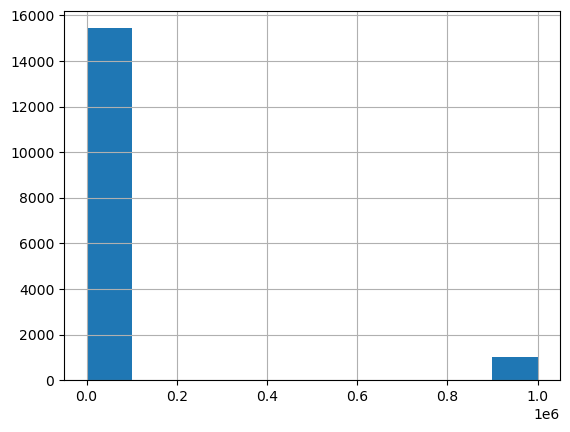

In [15]:
loans['dti_wprosper_loan'].hist()

In [16]:
loans.loc[ loans['dti_wprosper_loan'] > loans['dti_wprosper_loan'].quantile(0.95), 'dti_wprosper_loan'] \
    = loans['dti_wprosper_loan'].quantile(0.95)

<Axes: >

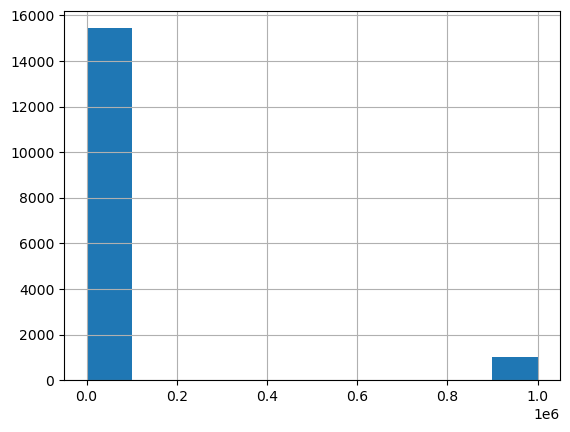

In [17]:
loans['dti_wprosper_loan'].hist()

In [18]:
loans['dti_wprosper_loan'].quantile(0.95)

1000000.0

In [19]:
#Sort by date
loans = loans.sort_values('origination_date')
loans = loans.reset_index(drop=True)

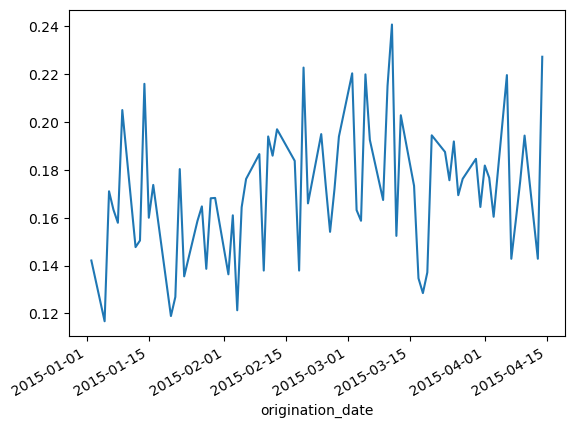

In [20]:
#Plot default rate vs. date
defaulted_byMonth = loans.groupby('origination_date')['defaulted'].mean()
fig = defaulted_byMonth.plot()

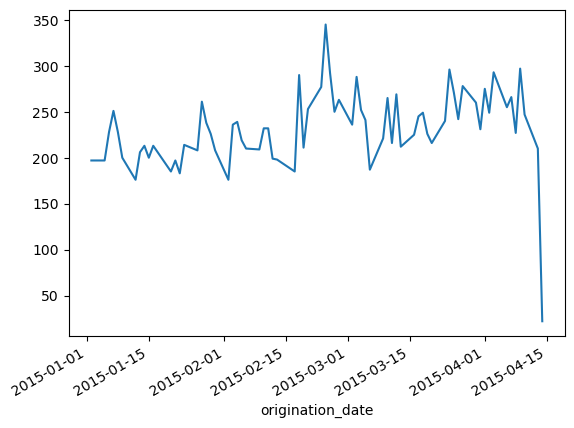

In [21]:
#How many loans issued per month?
issued_byMonth = loans.groupby('origination_date')['loan_number'].count()
fig = issued_byMonth.plot()

In [22]:
loans.head()

,loan_number,loan_status_description,origination_date,amount_borrowed,listing_monthly_payment,borrower_rate,stated_monthly_income,dti_wprosper_loan,prosper_rating,occupation,defaulted
0,254360,COMPLETED,2015-01-02,6000.0,188.54,0.0819,2083.3333,0.24,A,NaN,0
1,254920,COMPLETED,2015-01-02,2000.0,62.85,0.0819,1541.6667,0.16,A,Computer Programmer,0
2,254923,COMPLETED,2015-01-02,3000.0,91.58,0.0623,3750.0000,0.27,AA,Retail Management,0
3,254929,COMPLETED,2015-01-02,12000.0,408.56,0.1373,8333.3333,0.19,B,Professional,0
4,254931,COMPLETED,2015-01-02,25000.0,817.88,0.1095,8083.3333,0.30,A,Analyst,0


# Logit model: version 1

Model default as a function of loan amount, payment, interest rate, income, and dti

In [23]:
#specify and fit model
result = smf.logit('defaulted ~ amount_borrowed + listing_monthly_payment + borrower_rate + \
                    stated_monthly_income + dti_wprosper_loan', loans).fit()

Optimization terminated successfully.
         Current function value: 0.436047
         Iterations 7


In [24]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              defaulted   No. Observations:                16452
Model:                          Logit   Df Residuals:                    16446
Method:                           MLE   Df Model:                            5
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                 0.04597
Time:                        17:16:58   Log-Likelihood:                -7173.8
converged:                       True   LL-Null:                       -7519.5
Covariance Type:            nonrobust   LLR p-value:                3.747e-147
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.6497      0.097    -27.437      0.000      -2.839      -2.460
amount_borrowed            -0.0002   3.41e-05     -6.083      0.000      -0.000      -0.000
listing_monthly_payment     0.0066      0.001      6.641      0.000       0.005       0.009
borrower_rate               6.8530      0.567     12.091      0.000       5.742       7.964
stated_monthly_income   -1.674e-05   6.23e-06     -2.688      0.007   -2.89e-05   -4.54e-06
dti_wprosper_loan         9.45e-08   8.23e-08      1.148      0.251   -6.68e-08    2.56e-07
===========================================================================================
"""

In [25]:
# A good in-sample performance measure of the model is the pseudo R-squared
result.prsquared

0.04596678592879311

In [26]:
result.params

Intercept                 -2.649679e+00
amount_borrowed           -2.073514e-04
listing_monthly_payment    6.617323e-03
borrower_rate              6.853017e+00
stated_monthly_income     -1.674118e-05
dti_wprosper_loan          9.450468e-08
dtype: float64

In [27]:
#predicted probability of default
result.predict()

array([0.10718984, 0.10783678, 0.09099424, ..., 0.11993225, 0.08610121,
       0.18317056])

In [28]:
#most likely to default:
result.predict().max()

0.7193000104209959

In [29]:
#... and least likely to default:
result.predict().min()

2.627785824234777e-08

In [30]:
#fitted values are different - what is this?
result.fittedvalues

0       -2.119773
1       -2.113030
2       -2.301555
3       -1.632913
4       -1.806206
           ...   
16447   -2.052033
16448   -1.383538
16449   -1.993072
16450   -2.362196
16451   -1.495013
Length: 16452, dtype: float64

In [31]:
#first value
result.fittedvalues[0]

-2.1197725540006864

In [32]:
#logistic transformation of first value.
#... which equals the first loan default prob.
1.0/(1.0 + np.exp(-result.fittedvalues[0]))

0.10718983516371179

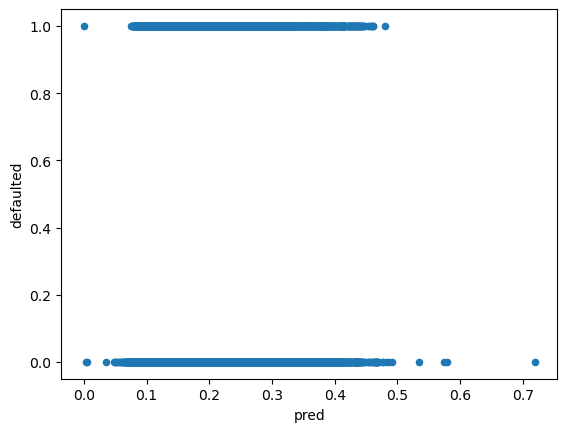

In [33]:
# Let's plot actual outcome vs. predicted default probability
plotdata = loans.copy()
plotdata['pred'] = result.predict()
fig = plotdata.plot(kind='scatter', x='pred', y='defaulted')

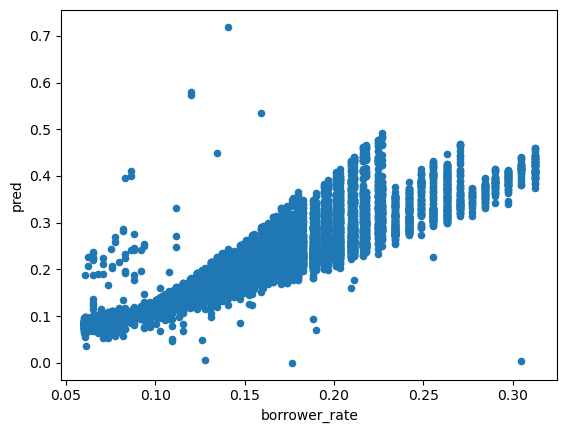

In [34]:
#And let's see how one of the variables affects the predicted default rate graphically
plotdata = plotdata[['pred', 'borrower_rate']]
fig = plotdata.plot(kind='scatter', x='borrower_rate', y='pred')

Optional: merge predicted values back into dataset and see how they line up with loan grades

In [35]:
#How do the predicted values line up with the Prosper loan grades?
loans2 = loans.copy()
loans2['pred'] = result.predict()
loans2

,loan_number,loan_status_description,origination_date,amount_borrowed,listing_monthly_payment,borrower_rate,stated_monthly_income,dti_wprosper_loan,prosper_rating,occupation,defaulted,pred
0,254360,COMPLETED,2015-01-02,6000.0,188.54,0.0819,2083.3333,0.24,A,NaN,0,0.107190
1,254920,COMPLETED,2015-01-02,2000.0,62.85,0.0819,1541.6667,0.16,A,Computer Programmer,0,0.107837
2,254923,COMPLETED,2015-01-02,3000.0,91.58,0.0623,3750.0000,0.27,AA,Retail Management,0,0.090994
3,254929,COMPLETED,2015-01-02,12000.0,408.56,0.1373,8333.3333,0.19,B,Professional,0,0.163432
4,254931,COMPLETED,2015-01-02,25000.0,817.88,0.1095,8083.3333,0.30,A,Analyst,0,0.141097
...,...,...,...,...,...,...,...,...,...,...,...,...
16447,309527,DEFAULTED,2015-04-14,2000.0,63.95,0.0938,3204.1667,0.26,A,Clerical,1,0.113847
16448,309524,COMPLETED,2015-04-14,12000.0,418.52,0.1543,4333.3333,0.39,C,Civil Service,0,0.200441
16449,309518,COMPLETED,2015-04-14,8000.0,256.86,0.0966,2766.1667,0.19,A,Other,0,0.119932
16450,309617,COMPLETED,2015-04-14,5000.0,152.22,0.0605,5833.3333,0.28,AA,Other,0,0.086101


In [36]:
loans2 = loans2.sort_values('prosper_rating')
loans2.groupby('prosper_rating')['pred'].describe()

,count,mean,std,min,25%,50%,75%,max
prosper_rating,,,,,,,,
AA,2434.0,0.090374,0.012897,3.581629e-02,0.084104,0.089573,0.095506,0.236366
A,4304.0,0.115639,0.017970,4.738218e-02,0.104566,0.114839,0.124396,0.409602
B,3745.0,0.154200,0.025790,4.946044e-03,0.138899,0.150283,0.164450,0.719300
C,3467.0,0.210333,0.038454,2.627786e-08,0.181902,0.201906,0.231551,0.533812
D,1610.0,0.291563,0.061364,6.949065e-02,0.245238,0.277550,0.328314,0.491148
E,648.0,0.339826,0.042661,2.271854e-01,0.308169,0.334119,0.371059,0.468624
HR,244.0,0.389313,0.038143,3.178835e-03,0.370502,0.389908,0.411220,0.460848


In [37]:
loans2.loc[(loans2['prosper_rating']=='AA') & (loans2['pred']>.33)]

,loan_number,loan_status_description,origination_date,amount_borrowed,listing_monthly_payment,borrower_rate,stated_monthly_income,dti_wprosper_loan,prosper_rating,occupation,defaulted,pred


In [38]:
#try some diffeent thresholds to see if our model predicte E loans better than just using the fact that they are E loans
#baseline
loans2.loc[loans2['prosper_rating']=='E']['defaulted'].mean()

0.30401234567901236

In [39]:
loans2.loc[(loans2['prosper_rating']=='E')&(loans2['pred']<=0.294515)]['defaulted'].mean()

0.28431372549019607

In [40]:
loans2.loc[(loans2['prosper_rating']=='E')&(loans2['pred']>=0.388864)]['defaulted'].mean()

0.25806451612903225

In [41]:
#save model to pickle file
result.save('Logit1.pkl', remove_data=True)

## Logit model: version 2

Add some calculated variables to version 1

In [42]:
#maybe the ratio of loan payment to income works better that the loan payment
loans.loc[loans['stated_monthly_income']==0, 'stated_monthly_income'] = 1.0
loans['pti'] = loans['listing_monthly_payment']/loans['stated_monthly_income']

In [43]:
loans['pti'].describe()

count    16452.000000
mean         0.084334
std          0.912255
min          0.000075
25%          0.040054
50%          0.066870
75%          0.101848
max         91.330000
Name: pti, dtype: float64

In [44]:
#un-ordered categorical variable example: occupation
loans['occupation'].value_counts().head(20)

occupation
Other                                3557
Professional                         1702
Executive                             626
Teacher                               525
Clerical                              508
Nurse (RN)                            492
Analyst                               469
Skilled Labor                         465
Computer Programmer                   429
Sales - Commission                    429
Construction                          402
Accountant/CPA                        397
Retail Management                     387
Sales - Retail                        380
Truck Driver                          376
Administrative Assistant              363
Police Officer/Correction Officer     270
Laborer                               261
Food Service Management               242
Food Service                          231
Name: count, dtype: int64

In [45]:
occ_dummies = pd.get_dummies(loans['occupation'])

In [46]:
loans = pd.merge(loans, occ_dummies, how='inner', left_index=True, right_index=True)

In [47]:
loans.head()

,loan_number,loan_status_description,origination_date,amount_borrowed,listing_monthly_payment,borrower_rate,stated_monthly_income,dti_wprosper_loan,prosper_rating,occupation,...,Student - Community College,Student - Technical School,Teacher,Teacher's Aide,Tradesman - Carpenter,Tradesman - Electrician,Tradesman - Mechanic,Tradesman - Plumber,Truck Driver,Waiter/Waitress
0,254360,COMPLETED,2015-01-02,6000.0,188.54,0.0819,2083.3333,0.24,A,NaN,...,False,False,False,False,False,False,False,False,False,False
1,254920,COMPLETED,2015-01-02,2000.0,62.85,0.0819,1541.6667,0.16,A,Computer Programmer,...,False,False,False,False,False,False,False,False,False,False
2,254923,COMPLETED,2015-01-02,3000.0,91.58,0.0623,3750.0000,0.27,AA,Retail Management,...,False,False,False,False,False,False,False,False,False,False
3,254929,COMPLETED,2015-01-02,12000.0,408.56,0.1373,8333.3333,0.19,B,Professional,...,False,False,False,False,False,False,False,False,False,False
4,254931,COMPLETED,2015-01-02,25000.0,817.88,0.1095,8083.3333,0.30,A,Analyst,...,False,False,False,False,False,False,False,False,False,False


In [48]:
loans.columns

Index(['loan_number', 'loan_status_description', 'origination_date',
       'amount_borrowed', 'listing_monthly_payment', 'borrower_rate',
       'stated_monthly_income', 'dti_wprosper_loan', 'prosper_rating',
       'occupation', 'defaulted', 'pti', 'Accountant/CPA',
       'Administrative Assistant', 'Analyst', 'Architect', 'Attorney',
       'Biologist', 'Bus Driver', 'Car Dealer', 'Chemist', 'Civil Service',
       'Clergy', 'Clerical', 'Computer Programmer', 'Construction', 'Dentist',
       'Doctor', 'Engineer - Chemical', 'Engineer - Electrical',
       'Engineer - Mechanical', 'Executive', 'Fireman', 'Flight Attendant',
       'Food Service', 'Food Service Management', 'Homemaker', 'Investor',
       'Judge', 'Laborer', 'Landscaping', 'Medical Technician',
       'Military Enlisted', 'Military Officer', 'Nurse (LPN)', 'Nurse (RN)',
       'Nurse - Licensed Practical Nurse (LPN)',
       'Nurse - Registered Nurse (RN)', 'Nurse's Aide', 'Other', 'Pharmacist',
       'Pilot - Priv

In [49]:
#specify and fit model
result = smf.logit('defaulted ~ amount_borrowed + listing_monthly_payment + borrower_rate + \
                    stated_monthly_income + dti_wprosper_loan + pti + Executive + Other + Clerical +\
                    Construction + Teacher', loans).fit()

Optimization terminated successfully.
         Current function value: 0.435650
         Iterations 7


In [50]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              defaulted   No. Observations:                16452
Model:                          Logit   Df Residuals:                    16440
Method:                           MLE   Df Model:                           11
Date:                Tue, 12 Mar 2024   Pseudo R-squ.:                 0.04684
Time:                        17:17:01   Log-Likelihood:                -7167.3
converged:                       True   LL-Null:                       -7519.5
Covariance Type:            nonrobust   LLR p-value:                6.271e-144
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -2.6125      0.098    -26.622      0.000      -2.805      -2.420
Executive[T.True]          -0.1708      0.121     -1.415      0.157      -0.407       0.066
Other[T.True]              -0.1386      0.054     -2.589      0.010      -0.244      -0.034
Clerical[T.True]            0.0708      0.120      0.589      0.556      -0.165       0.306
Construction[T.True]       -0.1236      0.140     -0.884      0.377      -0.398       0.151
Teacher[T.True]            -0.2787      0.132     -2.110      0.035      -0.537      -0.020
amount_borrowed            -0.0002   3.41e-05     -6.123      0.000      -0.000      -0.000
listing_monthly_payment     0.0067      0.001      6.689      0.000       0.005       0.009
borrower_rate               6.8401      0.567     12.060      0.000       5.729       7.952
stated_monthly_income   -1.587e-05   6.39e-06     -2.484      0.013   -2.84e-05   -3.35e-06
dti_wprosper_loan        1.106e-07   8.29e-08      1.333      0.182    -5.2e-08    2.73e-07
pti                        -0.0082      0.031     -0.260      0.795      -0.070       0.053
===========================================================================================
"""

In [51]:
#does this fit better?
result.prsquared

0.04683562914739792

In [52]:
result.predict()

array([0.11089199, 0.11149195, 0.09433694, ..., 0.10982075, 0.07878096,
       0.19456266])

In [53]:
#ROC curve
fpr, tpr, thresholds = metrics.roc_curve(loans['defaulted'], result.predict())

In [54]:
roc_auc = metrics.auc(fpr, tpr)

In [55]:
roc_auc

0.6657770529366465

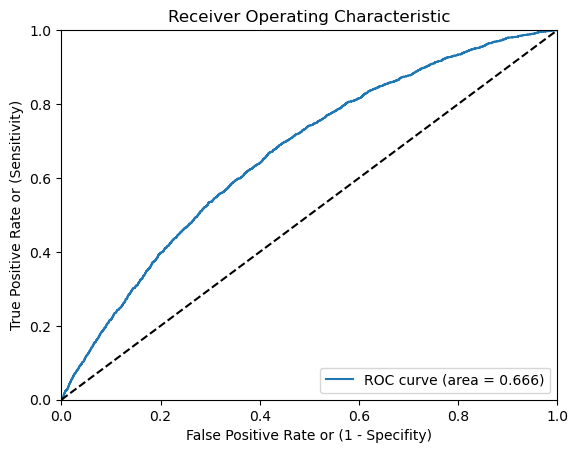

In [56]:
# Plot ROC curve
pylab.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
pylab.plot([0, 1], [0, 1], 'k--')  # random predictions curve
pylab.xlim([0.0, 1.0])
pylab.ylim([0.0, 1.0])
pylab.xlabel('False Positive Rate or (1 - Specifity)')
pylab.ylabel('True Positive Rate or (Sensitivity)')
pylab.title('Receiver Operating Characteristic')
pylab.legend(loc="lower right")

In [57]:
#Let's calculate AUC and plot for a naive model to compare
#just predict every loan has the mean default probability as the whole sample
pred_bad = np.copy(result.predict())
pred_bad[:] = loans['defaulted'].mean()
pred_bad

array([0.17073912, 0.17073912, 0.17073912, ..., 0.17073912, 0.17073912,
       0.17073912])

In [58]:
fpr, tpr, thresholds = metrics.roc_curve(loans['defaulted'], pred_bad)

In [59]:
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.5

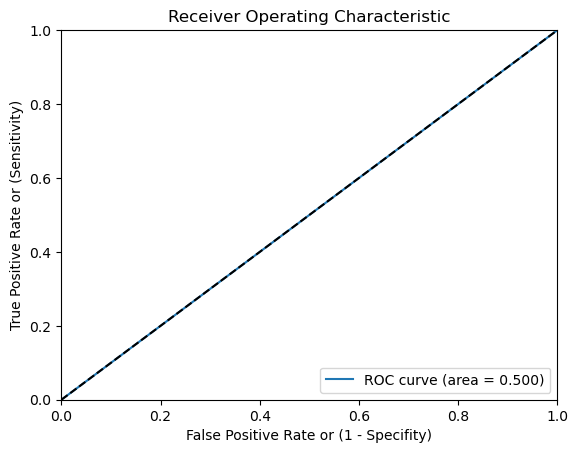

In [60]:
# Plot ROC curve
pylab.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
pylab.plot([0, 1], [0, 1], 'k--')  # random predictions curve
pylab.xlim([0.0, 1.0])
pylab.ylim([0.0, 1.0])
pylab.xlabel('False Positive Rate or (1 - Specifity)')
pylab.ylabel('True Positive Rate or (Sensitivity)')
pylab.title('Receiver Operating Characteristic')
pylab.legend(loc="lower right")

In [61]:
#And for a great model
#this uses the actual outcome in place of the prediction
pred = loans['defaulted'].copy()
#and reverses the first 500 loans so it is not quite perfect
pred[0:500] = 1 - pred[0:500]
fpr, tpr, thresholds = metrics.roc_curve(loans['defaulted'].values, pred.values)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.9719224030089146

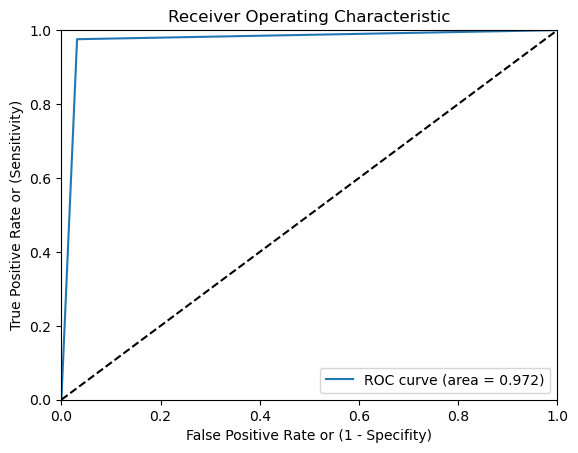

In [62]:
# Plot ROC curve
pylab.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
pylab.plot([0, 1], [0, 1], 'k--')  # random predictions curve
pylab.xlim([0.0, 1.0])
pylab.ylim([0.0, 1.0])
pylab.xlabel('False Positive Rate or (1 - Specifity)')
pylab.ylabel('True Positive Rate or (Sensitivity)')
pylab.title('Receiver Operating Characteristic')
pylab.legend(loc="lower right")

In [63]:
result.save('Logit2.pkl', remove_data=True)